# Computing saliency masks with the PAIRML saliency library (for TF2 and other frameworks)

This notebook demonstrates a number of saliency mask techniques, augmented with the `SmoothGrad` technique, using the VGG16 convolutional neural network in TF2. The intention of this notebook is to have as few dependencies as possible to show how to compute masks for ML frameowrks.

This notebook shows the following techniques, alongside with the `SmoothGrad` augmentation:

*   Vanilla Gradients
    ([paper](https://scholar.google.com/scholar?q=Visualizing+higher-layer+features+of+a+deep+network&btnG=&hl=en&as_sdt=0%2C22),
    [paper](https://arxiv.org/abs/1312.6034))
*   Integrated Gradients ([paper](https://arxiv.org/abs/1703.01365))
*   XRAI ([paper](https://arxiv.org/abs/1906.02825))
*   Grad-CAM ([paper](https://arxiv.org/abs/1610.02391))
*   Blur IG ([paper](https://arxiv.org/abs/2004.03383))
*   Guided IG ([paper](https://arxiv.org/abs/2106.09788))

This notebook assumes you have the `saliency` pip package installed. To install run (use `pip3` for python 3.x):
```
pip install saliency tensorflow
```

In [1]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P
from tensorflow import keras
# From our repository.
import saliency.core as saliency
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import cv2
import json
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

### Utility methods

In [2]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im, cmap='inferno')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = im.resize((224,224))
  im = np.asarray(im)
  return im

def PreprocessImage(im):
  im = tf.keras.applications.vgg16.preprocess_input(im)
  return im

### Loading the VGG16 model for ImageNet

In [3]:
#m = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
#unet_model = keras.models.load_model('C:/Users/jixia/cityscapes_segmentation/pretrained_models/unet')
unet_model = keras.models.load_model('C:/Users/jixia/cityscapes_segmentation/pretrained_models/segnet')
#unet_model = keras.models.load_model('C:/Users/jixia/cityscapes_segmentation/pretrained_models/vgg_unet')
#unet_model = keras.models.load_model('C:/Users/jixia/cityscapes_segmentation/pretrained_models/resnet50')
#unet_model = keras.models.load_model('C:/Users/jixia/cityscapes_segmentation/pretrained_models/AttVggUnet')

unet_model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
_______________________________________________________________________________________

In [4]:
#conv_layer = unet_model.get_layer('seg_feats')
conv_layer = unet_model.get_layer('conv2d_26')
model = tf.keras.models.Model([unet_model.inputs], [conv_layer.output, unet_model.output])

`call_model_function` is how we pass inputs to our model and receive outputs necessary to computer saliency masks. The description of this method and necessary outputs is in the base CoreSaliency description, as well as separately for each method.

### Load an image and infer

In [5]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    
    image = img[:,:256]
    mask = img[:,256:]
    
    return image, mask

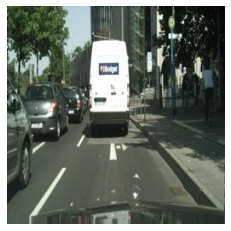

In [6]:
# Load the image
m='155.jpg'
valid_folder="C:/Users/jixia/cityscapes_segmentation/cityscapes_data/cityscapes_data/val"
m ,tru=LoadImage(m, valid_folder)
im_orig = m
im = PreprocessImage(im_orig)

# Show the image
ShowImage(im_orig)

_, predictions = model(np.array([im]))

prediction_pixel = predictions[0,50,40,1]

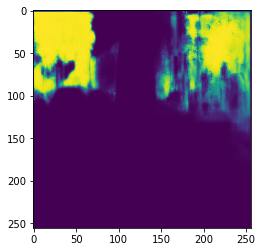

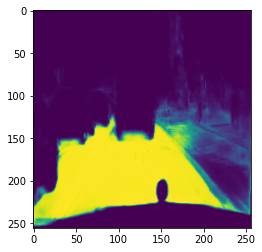

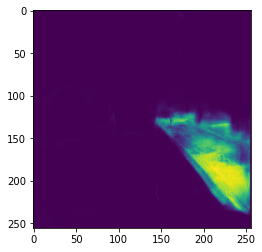

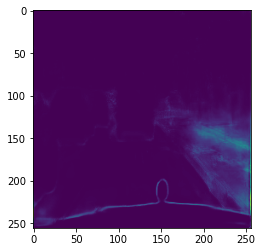

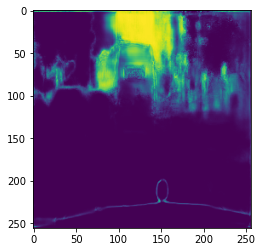

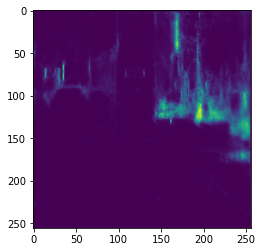

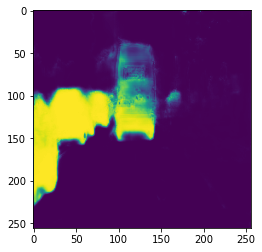

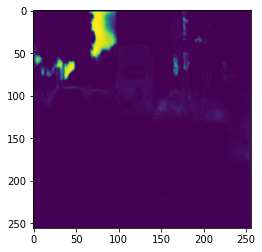

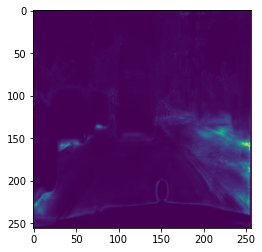

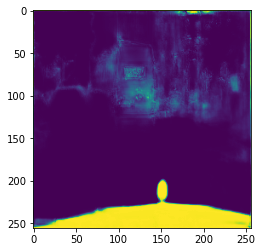

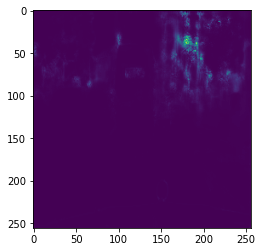

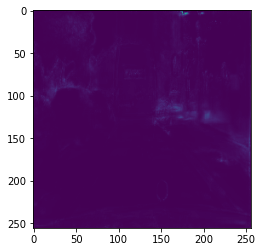

In [7]:
m = [np.float32(x) for x in m]
m = np.array(m)
img_tensor = np.expand_dims(m, 0)
output = unet_model.predict(img_tensor)
for i in range(12):
    plt.imshow(output[:,:,:,i].squeeze())
    plt.show()

In [8]:
print(predictions.shape)

(1, 256, 256, 13)


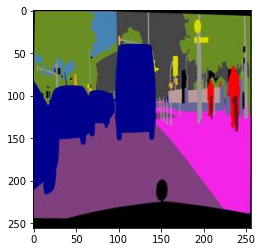

In [9]:
plt.imshow(tru)

In [10]:
class SuperRoI:  # or rename it to ClassRoI
    def __init__(self, image =None):
        self.image = image
        self.roi = 1
        self.fullroi = None
        self.i = None
        self.j = None

    def setRoIij(self):
        print("Shape of RoI: ", self.roi.shape)
        self.i = np.where(self.roi == 1)[0]
        self.j = np.where(self.roi == 1)[1]
        print("Lengths of i and j index lists:", len(self.i), len(self.j))

    def meshgrid(self):
        # mesh for contour
        ylist = np.linspace(0, self.image.shape[0], self.image.shape[0])
        xlist = np.linspace(0, self.image.shape[1], self.image.shape[1])
        return np.meshgrid(xlist, ylist) #returns X,Y
class PixelRoI(SuperRoI):
    def __init__(self, i, j, image):
        self.image = image
        self.roi = np.zeros((image.shape[-3], image.shape[-2]))
        self.roi[i, j] = 1
        self.i = i
        self.j = j


In [11]:
class ClassRoI(SuperRoI):
    def __init__(self, model, image, cls):
        #print('model.predict(np.expand_dims(image, 0))',model.predict(np.expand_dims(image, 0)).shape)
        preds = model.predict(np.expand_dims(image, 0))[0]
        #preds = tf.float32(model.get_layer(model.layers[-3].name).output[0])
        #print('preds.shape:',preds.shape)
        #print(preds.shape)
        max_preds = preds.argmax(axis=-1)  
        #print(max_preds,max_preds.shape)   
        #max_preds = tf.math.argmax(preds, axis = -1)
        self.image = image
        #self.roi = np.round(preds[..., cls] * (max_preds == cls)).reshape(image.shape[-3], image.shape[-2])
        self.roi = (preds[..., cls] * (max_preds == cls)).reshape(image.shape[-3], image.shape[-2])
        #print(max_preds == cls)
        #print(self.roi)
        self.fullroi = self.roi
        self.setRoIij()

    def connectedComponents(self):
        #all_labels = measure.label(self.fullroi.astype(int),background = 1)
        all_labels = self.fullroi.astype(int)
        print('all_labels:', all_labels)
        (values, counts) = np.unique(all_labels * (all_labels != 0), return_counts=True)
        #print("connectedComponents values, counts: ", values, counts)
        return all_labels, values, counts

    def largestComponent(self):
        all_labels, values, counts = self.connectedComponents()
        # find the largest component
        ind = np.argmax(counts[values != 0]) + 1  # +1 because indexing starts from 0 for the background
        print("argmax: ", ind)
        # define RoI
        self.roi = (all_labels == ind).astype(int)
        self.setRoIij()

    def smallestComponent(self):
        all_labels, values, counts = self.connectedComponents()
        ind = np.argmin(counts[values != 0]) + 1
        print("argmin: ", ind)  #
        self.roi = (all_labels == ind).astype(int)
        self.setRoIij()

In [12]:
with tf.GradientTape() as g:
    x = tf.constant([[1., 2.], [3., 4.]], dtype=tf.float32)
    g.watch(x)
    y = x * x
gradient = g.gradient(y, x)
print(gradient)


tf.Tensor(
[[2. 4.]
 [6. 8.]], shape=(2, 2), dtype=float32)


In [13]:
def call_model_function(images, roi, cls, expected_keys=None):
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            conv_output, output_layer = model(images)
            #print(output_layer.shape) #correct
            output_layer = output_layer[0,:,:,cls]
            #print(output_layer.shape) #correct
            output = output_layer*roi.roi
            #print('output',output.shape)
            #print(np.sum(output))
            #gradients = np.array(tape.gradient(output, images))
            gradients = tape.gradient(output,images)
            #print('gradients.shape', gradients.shape)
            #img_dim = images.shape[:2]
            #gradients = cv2.resize(gradients, img_dim[::-1], cv2.INTER_LINEAR)
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

### Vanilla Gradient & SmoothGrad

Shape of RoI:  (256, 256)
Lengths of i and j index lists: 0 0
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)


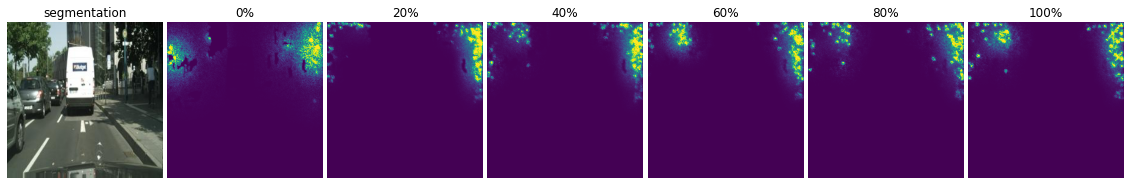

In [25]:
#cls = 0
#roi=PixelRoI(180,10,m)
#roi=PixelRoI(200,100,m)
cls = 0
clsroi = ClassRoI(unet_model, m, cls)
#print(clsroi.roi)
#clsroi = ClassRoI(model, m, cls)
#print(clsroi.roi)

model = tf.keras.models.Model([unet_model.inputs], [conv_layer.output, unet_model.output])
    
# Construct the saliency object. This alone doesn't do anything.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, clsroi, cls)
smoothgrad_mask_3d2 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=.2,
                      nsamples=25)
smoothgrad_mask_3d5 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=.4,
                      nsamples=25)
smoothgrad_mask_3d10 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=.6,
                      nsamples=25)
smoothgrad_mask_3d20 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=.8,
                      nsamples=25)
smoothgrad_mask_3d50 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=1.,
                      nsamples=25)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale2 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d2)
smoothgrad_mask_grayscale5 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d5)
smoothgrad_mask_grayscale10 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d10)
smoothgrad_mask_grayscale20 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d20)
smoothgrad_mask_grayscale50 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d50)
# Set up matplot lib figures.
ROWS = 1
COLS = 7
UPSCALE_FACTOR = 20
#P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ax = plt.subplot(1,7,1)
ax.set_title("segmentation")
plt.imshow(im_orig)
plt.axis('off')
ax = plt.subplot(1,7,2)
ax.set_title("0%")

plt.imshow(vanilla_mask_grayscale)
plt.axis('off')
ax = plt.subplot(1,7,3)
ax.set_title("20%")

plt.imshow(smoothgrad_mask_grayscale2)
plt.axis('off')
ax = plt.subplot(1,7,4)
ax.set_title("40%")

plt.imshow(smoothgrad_mask_grayscale5)
plt.axis('off')
ax = plt.subplot(1,7,5)
ax.set_title("60%")

plt.imshow(smoothgrad_mask_grayscale10)
plt.axis('off')
ax = plt.subplot(1,7,6)
ax.set_title("80%")
plt.imshow(smoothgrad_mask_grayscale20)
plt.axis('off')
ax = plt.subplot(1,7,7)
ax.set_title("100%")
plt.imshow(smoothgrad_mask_grayscale50)
plt.axis('off')
plt.subplots_adjust(wspace=0.03, hspace=0)
#ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 2))
#ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 3))

In [ ]:
#cls = 0
#roi=PixelRoI(180,10,m)
#roi=PixelRoI(200,100,m)
cls = 4
clsroi = ClassRoI(unet_model, m, cls)
#print(clsroi.roi)
#clsroi = ClassRoI(model, m, cls)
#print(clsroi.roi)

model = tf.keras.models.Model([unet_model.inputs], [conv_layer.output, unet_model.output])
    
# Construct the saliency object. This alone doesn't do anything.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, clsroi, cls)
smoothgrad_mask_3d2 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=.2,
                      nsamples=25)
smoothgrad_mask_3d5 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=.4,
                      nsamples=25)
smoothgrad_mask_3d10 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=.6,
                      nsamples=25)
smoothgrad_mask_3d20 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=.8,
                      nsamples=25)
smoothgrad_mask_3d50 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=1.,
                      nsamples=25)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale2 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d2)
smoothgrad_mask_grayscale5 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d5)
smoothgrad_mask_grayscale10 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d10)
smoothgrad_mask_grayscale20 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d20)
smoothgrad_mask_grayscale50 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d50)
# Set up matplot lib figures.
ROWS = 1
COLS = 7
UPSCALE_FACTOR = 20
#P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ax = plt.subplot(1,7,1)
ax.set_title("segmentation")
plt.imshow(im_orig)
plt.axis('off')
ax = plt.subplot(1,7,2)
ax.set_title("0%")

plt.imshow(vanilla_mask_grayscale)
plt.axis('off')
ax = plt.subplot(1,7,3)
ax.set_title("20%")

plt.imshow(smoothgrad_mask_grayscale2)
plt.axis('off')
ax = plt.subplot(1,7,4)
ax.set_title("40%")

plt.imshow(smoothgrad_mask_grayscale5)
plt.axis('off')
ax = plt.subplot(1,7,5)
ax.set_title("60%")

plt.imshow(smoothgrad_mask_grayscale10)
plt.axis('off')
ax = plt.subplot(1,7,6)
ax.set_title("80%")
plt.imshow(smoothgrad_mask_grayscale20)
plt.axis('off')
ax = plt.subplot(1,7,7)
ax.set_title("100%")
plt.imshow(smoothgrad_mask_grayscale50)
plt.axis('off')
plt.subplots_adjust(wspace=0.03, hspace=0)
#ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 2))
#ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 3))

Shape of RoI:  (256, 256)
Lengths of i and j index lists: 0 0


In [ ]:
#cls = 0
#roi=PixelRoI(180,10,m)
#roi=PixelRoI(200,100,m)
cls = 4
clsroi = ClassRoI(unet_model, m, cls)
#print(clsroi.roi)
#clsroi = ClassRoI(model, m, cls)
#print(clsroi.roi)

model = tf.keras.models.Model([unet_model.inputs], [conv_layer.output, unet_model.output])
    
# Construct the saliency object. This alone doesn't do anything.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, clsroi, cls)
smoothgrad_mask_3d2 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=.2,
                      nsamples=25)
smoothgrad_mask_3d5 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=.4,
                      nsamples=25)
smoothgrad_mask_3d10 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=.6,
                      nsamples=25)
smoothgrad_mask_3d20 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=.8,
                      nsamples=25)
smoothgrad_mask_3d50 = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls, stdev_spread=1.,
                      nsamples=25)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale2 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d2)
smoothgrad_mask_grayscale5 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d5)
smoothgrad_mask_grayscale10 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d10)
smoothgrad_mask_grayscale20 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d20)
smoothgrad_mask_grayscale50 = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d50)
# Set up matplot lib figures.
ROWS = 1
COLS = 7
UPSCALE_FACTOR = 20
#P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ax = plt.subplot(1,7,1)
ax.set_title("segmentation")
plt.imshow(im_orig)
plt.axis('off')
ax = plt.subplot(1,7,2)
ax.set_title("0%")

plt.imshow(vanilla_mask_grayscale)
plt.axis('off')
ax = plt.subplot(1,7,3)
ax.set_title("20%")

plt.imshow(smoothgrad_mask_grayscale2)
plt.axis('off')
ax = plt.subplot(1,7,4)
ax.set_title("40%")

plt.imshow(smoothgrad_mask_grayscale5)
plt.axis('off')
ax = plt.subplot(1,7,5)
ax.set_title("60%")

plt.imshow(smoothgrad_mask_grayscale10)
plt.axis('off')
ax = plt.subplot(1,7,6)
ax.set_title("80%")
plt.imshow(smoothgrad_mask_grayscale20)
plt.axis('off')
ax = plt.subplot(1,7,7)
ax.set_title("100%")
plt.imshow(smoothgrad_mask_grayscale50)
plt.axis('off')
plt.subplots_adjust(wspace=0.03, hspace=0)
#ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 2))
#ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 3))

Shape of RoI:  (256, 256)
Lengths of i and j index lists: 0 0
image_2d.shape (256, 256)
image_2d.shape (256, 256)


C:\Users\jixia\cityscapes_segmentation\saliency-master\saliency\core\visualization.py:28: RuntimeWarning: invalid value encountered in true_divide
  return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)
C:\Users\jixia\anaconda3\envs\tf\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\jixia\anaconda3\envs\tf\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\jixia\anaconda3\envs\tf\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


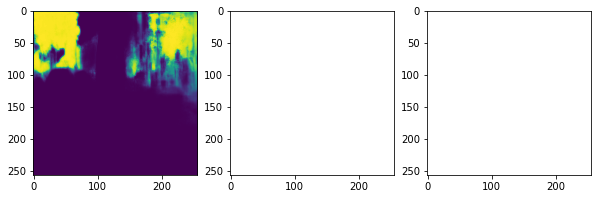

In [15]:
#roi=PixelRoI(200,100,m)
cls = 0
clsroi = ClassRoI(model, m, cls)
#print(clsroi.roi)

model = tf.keras.models.Model([unet_model.inputs], [conv_layer.output, unet_model.output])
    
# Construct the saliency object. This alone doesn't do anything.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, clsroi, cls)
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, clsroi, cls)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 10
#P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
plt.subplot(1,3,1)
plt.imshow(output[:,:,:,cls].squeeze())
plt.title='Segmentation'
plt.subplot(1,3,2)
plt.imshow(vanilla_mask_grayscale)
plt.title='Vanilla Gradient'
plt.subplot(1,3,3)
plt.imshow(smoothgrad_mask_grayscale)
plt.title='SmoothGrad'
#ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 2))
#ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 3))

image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)
image_2d.shape (256, 256)


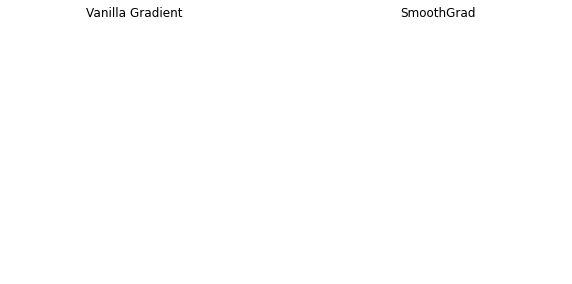

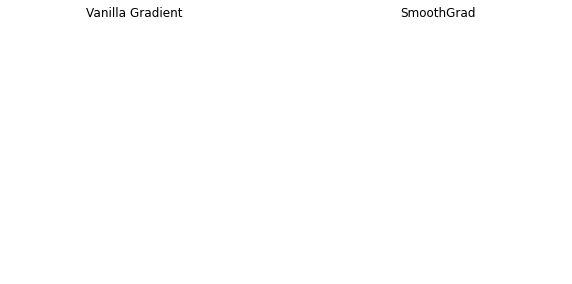

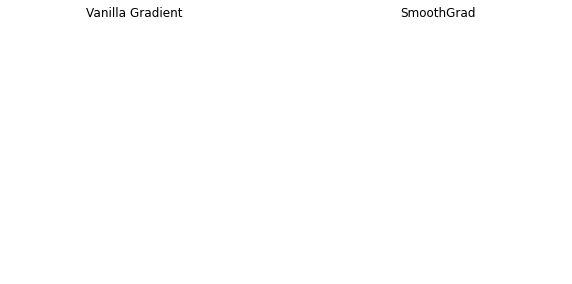

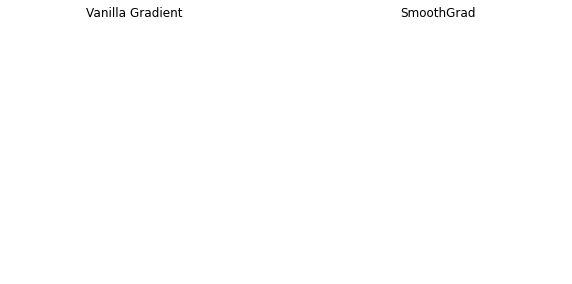

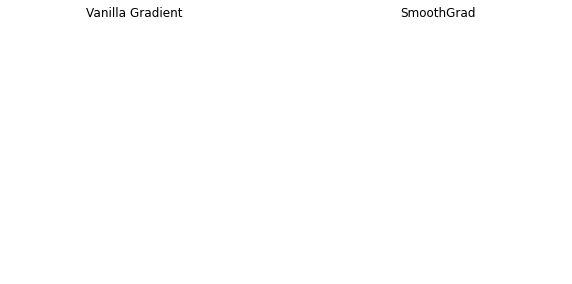

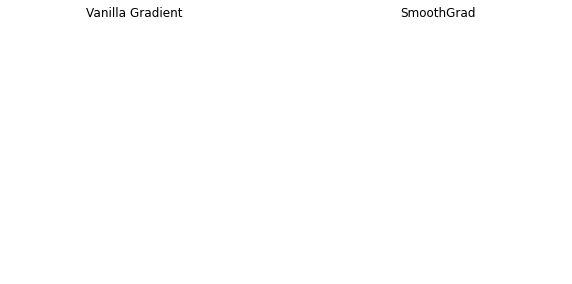

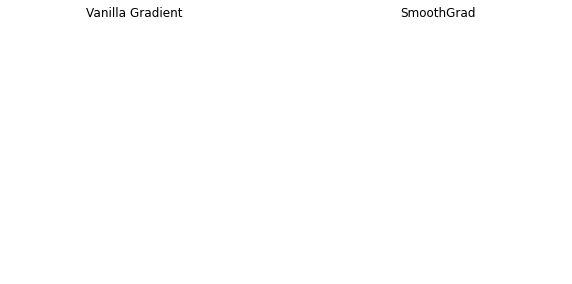

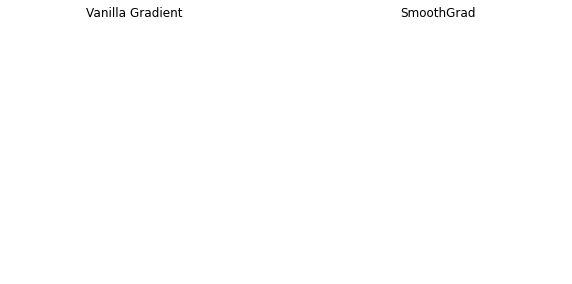

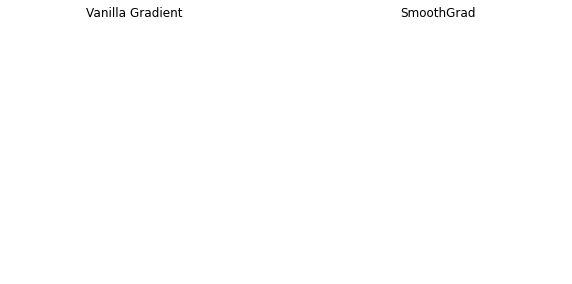

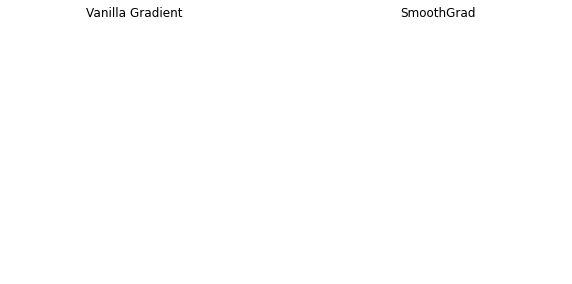

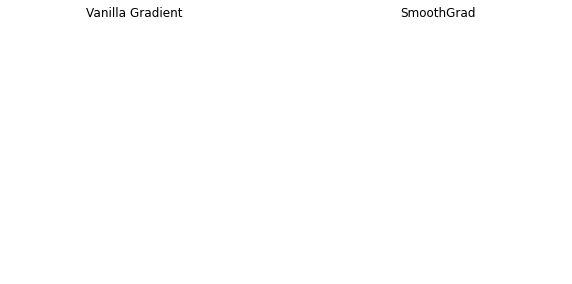

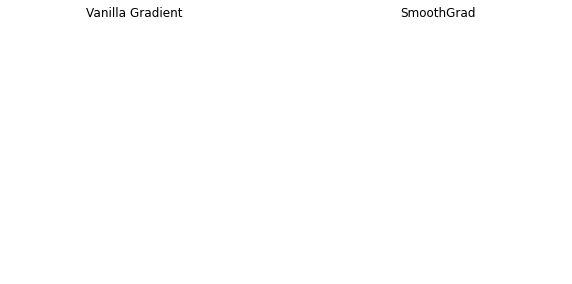

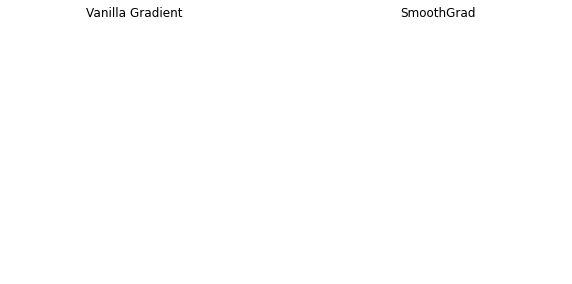

In [16]:
for i in range(13):
    roi=PixelRoI(125,125,m)
    cls = i
    model = tf.keras.models.Model([unet_model.inputs], [conv_layer.output, unet_model.output])
    
    # Construct the saliency object. This alone doesn't do anything.
    gradient_saliency = saliency.GradientSaliency()

    # Compute the vanilla mask and the smoothed mask.
    vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, roi, cls)
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, roi, cls)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

    # Set up matplot lib figures.
    ROWS = 1
    COLS = 2
    UPSCALE_FACTOR = 10
    P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

    # Render the saliency masks.
    ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
    ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

image_2d.shape (256, 256)
image_2d.shape (256, 256)


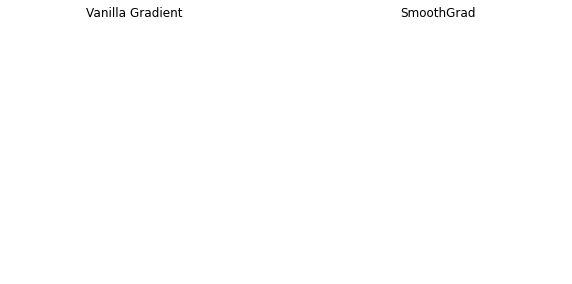

In [17]:
roi=PixelRoI(125,125,m)
cls = 0
conv_layer = unet_model.get_layer('conv2d_3')
model = tf.keras.models.Model([unet_model.inputs], [conv_layer.output, unet_model.output])
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, roi, cls)
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, roi, cls)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

### Integrated Gradients & SmoothGrad

For saliency methods that compute gradients along a path (e.g. Integrated Gradients), we can pass a batch_size parameter, which will batch the different steps along the path together so that the model isn't called for each individual step. When using this parameter, be sure that you are not overloading memory, as a very large batch size could crash the program.

In [18]:
# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

NameError: name 'call_model_args' is not defined

### XRAI Full and Fast

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 70)
im_mask = np.array(im_orig)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))

In [ ]:
# Create XRAIParameters and set the algorithm to fast mode which will produce an approximate result.
xrai_params = saliency.XRAIParameters()
xrai_params.algorithm = 'fast'

# Compute XRAI attributions with fast algorithm
xrai_attributions_fast = xrai_object.GetMask(im, call_model_function, call_model_args, extra_parameters=xrai_params, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions_fast, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions_fast > np.percentile(xrai_attributions_fast, 70)
im_mask = np.array(im_orig)
im_mask[~mask] = 0
ShowImage(im_mask, 'Top 30%', ax=P.subplot(ROWS, COLS, 3))

### Grad-CAM

In [ ]:
# Compare Grad-CAM and Smoothgrad with Grad-CAM.

# Construct the saliency object. This alone doesn't do anthing.
grad_cam = saliency.GradCam()

# Compute the Grad-CAM mask and Smoothgrad+Grad-CAM mask.
grad_cam_mask_3d = grad_cam.GetMask(im, call_model_function, call_model_args)
smooth_grad_cam_mask_3d = grad_cam.GetSmoothedMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(grad_cam_mask_3d)
smooth_grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_grad_cam_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(grad_cam_mask_grayscale, title='Grad-CAM', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smooth_grad_cam_mask_grayscale, title='Smoothgrad Grad-CAM', ax=P.subplot(ROWS, COLS, 2))

### Guided IG

In [ ]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = saliency.IntegratedGradients()
guided_ig = saliency.GuidedIG()

# Baseline is a black image for vanilla integrated gradients.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the Guided IG mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
guided_ig_mask_3d = guided_ig.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, max_dist=1.0, fraction=0.5)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
guided_ig_mask_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(guided_ig_mask_grayscale, title='Guided Integrated Gradients', ax=P.subplot(ROWS, COLS, 3))

### Blur IG

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()
blur_ig = saliency.BlurIG()

# Baseline is a black image for vanilla integrated gradients.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the Blur IG mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
blur_ig_mask_3d = blur_ig.GetMask(
  im, call_model_function, call_model_args, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(blur_ig_mask_grayscale, title='Blur Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

In [ ]:
# Compare BlurIG and Smoothgrad with BlurIG. Note: This will take a long time to run.

# Construct the saliency object. This alone doesn't do anthing.
blur_ig = saliency.BlurIG()

# Compute the Blur IG mask and Smoothgrad+BlurIG mask.
blur_ig_mask_3d = blur_ig.GetMask(im, call_model_function, call_model_args, batch_size=20)
# Smoothed mask for BlurIG will take a while since we are doing nsamples * nsamples computations.
smooth_blur_ig_mask_3d = blur_ig.GetSmoothedMask(im, call_model_function, call_model_args, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)
smooth_blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_blur_ig_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(blur_ig_mask_grayscale, title='Blur Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smooth_blur_ig_mask_grayscale, title='Smoothgrad Blur IG', ax=P.subplot(ROWS, COLS, 2))
